In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import defaultdict
import math
import seaborn as sns
import gym
from gym import spaces
from torch.utils.data import Dataset, DataLoader
from torch.distributions import Categorical
from multiprocessing import Pool
from tqdm import tqdm

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
class DiskPlacementEnv(gym.Env):

    def __init__(self, side_length=10, disk_radius=1, volume_fraction=0.3):
        super(DiskPlacementEnv, self).__init__()
        self.side_length = side_length
        self.disk_radius = disk_radius
        self.volume_fraction = volume_fraction
        
        # Calculate the number of disks needed to satisfy the volume fraction
        self.total_area = self.side_length ** 2
        self.disk_area = np.pi * self.disk_radius ** 2
        self.num_disks = int(self.volume_fraction * self.total_area / self.disk_area)
        
        # Define the action and observation spaces
        self.action_space = spaces.Discrete(self.side_length * self.side_length)
        self.observation_space = spaces.Box(
            low=0, high=1, shape=(self.side_length, self.side_length), dtype=np.float32
        )
        
        # State variables
        self.disk_positions = []
        self.remaining_disks = self.num_disks

    def reset(self):
        self.disk_positions = []
        self.remaining_disks = self.num_disks
        return self._get_observation()
    
    def _get_observation(self):
        # Create a grid representing the current state
        grid = np.zeros((self.side_length, self.side_length), dtype=np.float32)
        for (x, y) in self.disk_positions:
            grid[x, y] = 1
        return grid

    def _is_position_within_bounds(self, x, y):
        # Check if the position (x, y) is within the bounds of the grid
        return 0 <= x < self.side_length and 0 <= y < self.side_length

    def _is_overlap(self, x, y):
        # Vectorized check for overlap
        if not self.disk_positions:
            return False
        
        disk_positions_np = np.array(self.disk_positions)
        dx = np.minimum(np.abs(disk_positions_np[:, 0] - x), self.side_length - np.abs(disk_positions_np[:, 0] - x))
        dy = np.minimum(np.abs(disk_positions_np[:, 1] - y), self.side_length - np.abs(disk_positions_np[:, 1] - y))
        distances = np.sqrt(dx**2 + dy**2)
        
        return np.any(distances < 2 * self.disk_radius)

    def _is_valid_position(self, x, y):
        # Check the position in the main grid
        if not self._is_position_within_bounds(x, y):
            return False

        if self._is_overlap(x, y):
            return False
            
        return True

    def step(self, action):
        x = action // self.side_length
        y = action % self.side_length
        
        if self._is_valid_position(x, y):
            self.disk_positions.append((x, y))
            self.remaining_disks -= 1
            done = self.remaining_disks == 0
            reward = self._compute_reward()
            return self._get_observation(), reward, done, {}
        else:
            # Invalid move, penalize
            reward = -1
            return self._get_observation(), reward, False, {}

    def _compute_reward(self):
        # Simple reward: penalize overlap, reward coverage
        overlap_penalty = sum(
            not self._is_valid_position(x, y) for (x, y) in self.disk_positions
        )
        coverage_reward = len(self.disk_positions)
        return coverage_reward - overlap_penalty

    def render(self, mode='human'):
        fig, ax = plt.subplots()
        ax.set_xlim(0, self.side_length)
        ax.set_ylim(0, self.side_length)
        for (x, y) in self.disk_positions:
            circle = plt.Circle((x, y), self.disk_radius, color='blue', fill=True)
            ax.add_patch(circle)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.show()

class DiskPlacementCNN(nn.Module):
    def __init__(self, side_length, metadata_dim):
        super(DiskPlacementCNN, self).__init__()
        
        # Convolutional layers for processing the grid state
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # Fully connected layers for combining grid features with metadata
        conv_output_size = (side_length // 2 // 2) ** 2 * 64  # after two max-pooling layers
        self.fc1 = nn.Linear(conv_output_size + metadata_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)  # Output layer for regression task (reward prediction)

    def forward(self, grid, metadata):
        # Process the grid state through convolutional layers
        x = self.pool(F.relu(self.conv1(grid)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        
        # Flatten the output from conv layers
        x = x.view(x.size(0), -1)
        
        # Concatenate with metadata
        x = torch.cat((x, metadata), dim=1)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        embedding = F.relu(self.fc2(x))  # This is the embedding we want to extract
        output = self.fc3(embedding)

        return output, embedding

class DiskPlacementDataset(Dataset):
    def __init__(self, grids, metadata, rewards):
        self.grids = grids
        self.metadata = metadata
        self.rewards = rewards

    def __len__(self):
        return len(self.grids)

    def __getitem__(self, idx):
        grid = self.grids[idx]
        metadata = self.metadata[idx]
        reward = self.rewards[idx]
        return torch.tensor(grid, dtype=torch.float32).unsqueeze(0), torch.tensor(metadata, dtype=torch.float32), torch.tensor(reward, dtype=torch.float32)

class ValueNet(nn.Module):
    def __init__(self, embedding_dim, metadata_dim, action_space):
        super(ValueNet, self).__init__()
        self.fc1 = nn.Linear(embedding_dim + metadata_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, action_space)
        
    def forward(self, embedding, metadata):
        x = torch.cat((embedding, metadata), dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        action_probs = F.softmax(self.fc3(x), dim=1)
        return action_probs
    
class PolicyNet(nn.Module):
    def __init__(self, embedding_dim, metadata_dim, side_length):
        super(PolicyNet, self).__init__()
        self.fc1 = nn.Linear(embedding_dim + metadata_dim, 256)
        self.fc2 = nn.Linear(256, 512)
        self.deconv1 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv4 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv5 = nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding=1)
        
    def forward(self, embedding, metadata):
        x = torch.cat((embedding, metadata), dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = x.view(x.size(0), 512, 1, 1)  # Reshape for deconvolution
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = F.relu(self.deconv3(x))
        x = F.relu(self.deconv4(x))
        embedding_output = torch.sigmoid(self.deconv5(x))
        return embedding_output    

class CombinedNetwork(nn.Module):
    def __init__(self, embedding_dim, metadata_dim, side_length, action_space):
        super(CombinedNetwork, self).__init__()
        self.value_net = ValueNet(embedding_dim, metadata_dim, action_space)
        self.policy_net = PolicyNet(embedding_dim, metadata_dim, side_length)
        
    def forward(self, embedding, metadata):
        action_probs = self.value_net(embedding, metadata)
        embedding_output = self.policy_net(embedding, metadata)
        return action_probs, embedding_output

In [3]:
def generate_dataset(env, num_samples):
    grids = []
    metadata = []
    rewards = []

    for _ in range(num_samples):
        obs = env.reset()
        done = False
        episode_grids = []
        episode_metadata = []
        episode_reward = 0

        iteration = 0
        while not done and iteration < 500:
            action = env.action_space.sample()  # Random action
            next_obs, reward, done, info = env.step(action)
            episode_grids.append(obs)
            episode_metadata.append([env.disk_radius, env.remaining_disks])
            episode_reward += reward
            obs = next_obs
            iteration += 1

        # Store the final state and cumulative reward for the episode
        grids.append(episode_grids[-1])
        metadata.append(episode_metadata[-1])
        rewards.append(episode_reward)

    return np.array(grids), np.array(metadata), np.array(rewards)

## Data creation and CNN pre-training

In [4]:
side_length = 20
metadata_dim = 2
env = DiskPlacementEnv(side_length=side_length, disk_radius=1, volume_fraction=0.4)
num_samples = 5000
grids, metadata, rewards = generate_dataset(env, num_samples)

In [5]:
# Create Dataset and DataLoader
dataset = DiskPlacementDataset(grids, metadata, rewards)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

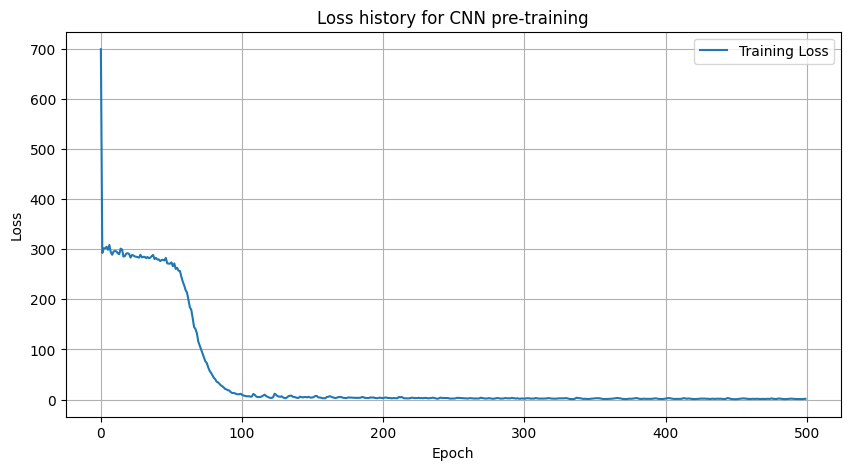

In [6]:
# CNN training to predict rewards
cnn_model = DiskPlacementCNN(side_length, metadata_dim).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

# Training loop
num_epochs = 500
loss_history = []

for epoch in tqdm(range(num_epochs), desc="Epochs"):
    epoch_loss = 0.0
    for grid, metadata, reward in dataloader:
        # Move tensors to the GPU if available
        grid = grid.to(device)
        metadata = metadata.to(device)
        reward = reward.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs, _ = cnn_model(grid, metadata)
        loss = criterion(outputs, reward.view(-1, 1))

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    # Calculate average loss for the epoch
    epoch_loss /= len(dataloader)
    loss_history.append(epoch_loss)

plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss history for CNN pre-training')
plt.legend()
plt.grid(True)
plt.show()

## PPO settings

In [18]:
# PPO hyperparameters
gamma = 0.99       # Discount factor for future rewards
lr = 1e-3          # Learning rate for the optimizer
eps_clip = 0.4     # Clipping parameter for PPO to avoid large policy updates
K_epochs = 8       # Number of epochs to update the policy at each PPO update
T_horizon = 4000   # Time horizon for collecting trajectories

class PPO:
    def __init__(self, embedding_dim, metadata_dim, side_length, action_space):
        self.policy = CombinedNetwork(embedding_dim, metadata_dim, side_length, action_space).to(device)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)
        self.policy_old = CombinedNetwork(embedding_dim, metadata_dim, side_length, action_space).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())
        self.MseLoss = nn.MSELoss()
        
    def select_action(self, state, metadata, action_mask):
        with torch.no_grad():
            embedding = cnn_model(state, metadata)[1]
            action_probs, _ = self.policy_old(embedding, metadata)
            
            # Apply the action mask
            action_probs = action_probs * action_mask
            action_probs = action_probs / action_probs.sum()  # Normalize the probabilities
            
            dist = Categorical(action_probs)
            action = dist.sample()
            return action.item(), dist.log_prob(action)
        
    def update(self, memory):
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(memory.rewards), reversed(memory.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (gamma * discounted_reward)
            rewards.insert(0, discounted_reward)
        
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        old_states = torch.stack(memory.states).to(device).detach().squeeze(1)
        old_metadata = torch.stack(memory.metadata).to(device).detach().squeeze(1)
        old_actions = torch.tensor(memory.actions).to(device).detach()
        old_logprobs = torch.tensor(memory.logprobs).to(device).detach()
        
        total_loss = 0
        for _ in range(K_epochs):
            #print(old_states.shape, old_metadata.shape)
            embedding = cnn_model(old_states, old_metadata)[1]
            action_probs, _ = self.policy(embedding, old_metadata)
            dist = Categorical(action_probs)
            
            new_logprobs = dist.log_prob(old_actions)
            dist_entropy = dist.entropy()
            state_values = self.policy.value_net(embedding, old_metadata).squeeze(1)
            # Ensure rewards is the same shape as state_values for broadcasting
            rewards_expanded = rewards.unsqueeze(1).expand_as(state_values)
            
            #print(rewards_expanded.shape, state_values.shape, new_logprobs.shape, old_logprobs.shape)
            advantages = rewards_expanded - state_values.detach()
            
            ratios = torch.exp(new_logprobs - old_logprobs.detach())
            ratios_expanded = ratios.unsqueeze(1).expand_as(advantages)
            #print(ratios_expanded.shape, advantages.shape)
            surr1 = ratios_expanded * advantages
            surr2 = torch.clamp(ratios_expanded, 1 - eps_clip, 1 + eps_clip) * advantages
            #print(surr1.shape, surr2.shape)
            
            loss = -torch.min(surr1, surr2).mean() + 0.5 * self.MseLoss(state_values, rewards_expanded).mean() - 0.01 * dist_entropy.mean()
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item()
        
        self.policy_old.load_state_dict(self.policy.state_dict())
        return total_loss / K_epochs

In [19]:
class Memory:
    def __init__(self):
        self.actions = []
        self.states = []
        self.metadata = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []

    def clear_memory(self):
        del self.actions[:]
        del self.states[:]
        del self.metadata[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.is_terminals[:]

## Training loop

In [20]:
action_dim = side_length * side_length  # Number of possible actions (grid cells)
embedding_dim = 64 # Should match the output size of the CNN's layer before the final output layer

ppo = PPO(embedding_dim, metadata_dim, side_length, action_dim)
memory = Memory()

Episode 0 completed, total loss: -0.056411533150821924
Episode 10 completed, total loss: -0.05819897400215268
Episode 20 completed, total loss: -0.05820087203755975
Episode 30 completed, total loss: -0.058215375524014235
Episode 40 completed, total loss: -0.058211625553667545
Episode 50 completed, total loss: -0.0582040217705071
Episode 60 completed, total loss: -0.05820839153602719
Episode 70 completed, total loss: -0.05819362588226795
Episode 80 completed, total loss: -0.05819451995193958
Episode 90 completed, total loss: -0.058205469977110624


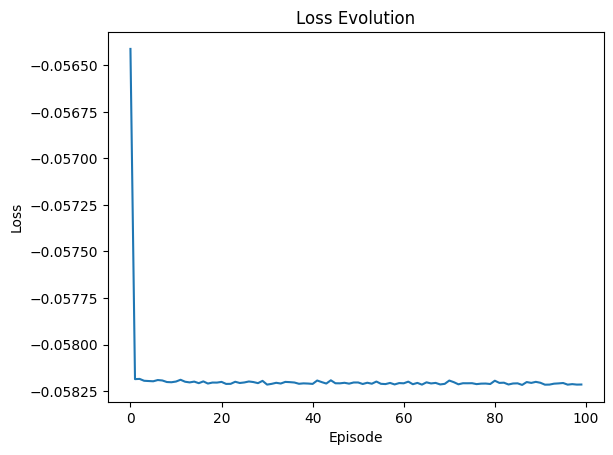

In [21]:
# Training loop
num_episodes = 100
max_iterations = 300  # Set a maximum number of iterations per episode

# Store the loss values for monitoring
losses = []
for episode in range(num_episodes):
    state = env.reset()
    metadata = np.array([0, 0])  # Dummy metadata, replace with actual metadata if available
    done = False
    total_loss = 0  # Initialize total loss for the episode
    
    for iteration in range(max_iterations):
        if done:
            break
        
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
        metadata_tensor = torch.tensor(metadata, dtype=torch.float32).unsqueeze(0).to(device)
        
        # Define the action mask for the current state
        action_mask = torch.ones(action_dim, dtype=torch.float32).to(device)
        # Set invalid actions to 0 in the mask
        action_mask = action_mask.view(side_length, side_length)
        for i in range(side_length):
            for j in range(side_length):
                if not env._is_valid_position(i, j):  # Use your environment's validity check
                    action_mask[i, j] = 0
        action_mask = action_mask.view(-1)
        
        action, log_prob = ppo.select_action(state_tensor, metadata_tensor, action_mask)
        #print(action, log_prob)
        next_state, reward, done, _ = env.step(action)
        
        memory.states.append(state_tensor)
        memory.metadata.append(metadata_tensor)
        memory.actions.append(action)
        memory.logprobs.append(log_prob)
        memory.rewards.append(reward)
        memory.is_terminals.append(done)
        
        state = next_state
    
    # Perform PPO update and calculate the average loss for monitoring
    loss = ppo.update(memory)
    memory.clear_memory()
    
    losses.append(loss)
    total_loss += loss
    
    if episode % 10 == 0:
        print(f"Episode {episode} completed, total loss: {total_loss}")

plt.plot(losses)
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.title('Loss Evolution')
plt.show()

## Testing env with model

Test Episode 1 completed, Reward: 0, Done: True, Iterations: 50, Remaining Disks: 0, Nb disks: 50


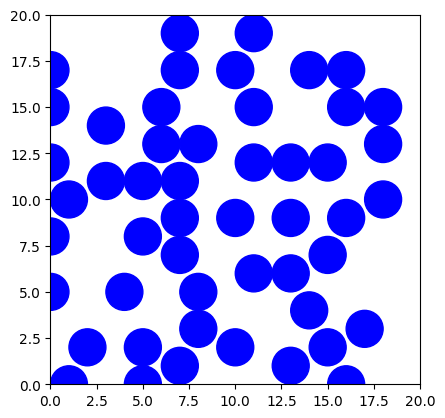

Test Episode 2 completed, Reward: 0, Done: True, Iterations: 50, Remaining Disks: 0, Nb disks: 50


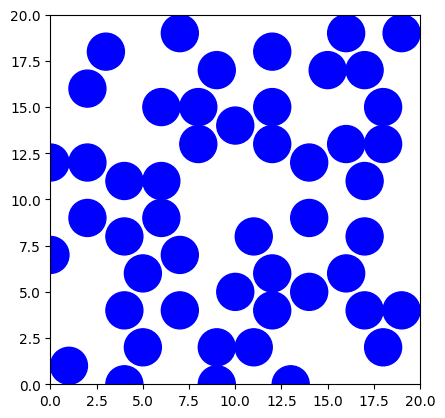

In [22]:
# If model saved, load it
# ppo = PPO(embedding_dim, metadata_dim, side_length, action_dim)
# ppo.policy.load_state_dict(torch.load('ppo_policy.pth'))  # Load the trained policy network
# env = DiskPlacementEnv(side_length=10, disk_radius=1, volume_fraction=0.3)

num_test_episodes = 2
for episode in range(num_test_episodes):
    state = env.reset()
    metadata = np.array([1, 0.3])
    done = False
    iteration = 0
    
    while not done and iteration < 200:
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
        metadata_tensor = torch.tensor(metadata, dtype=torch.float32).unsqueeze(0).to(device)
        
        # Define the action mask for the current state
        action_mask = torch.ones(action_dim, dtype=torch.float32).to(device)
        action_mask = action_mask.view(side_length, side_length)
        for i in range(side_length):
            for j in range(side_length):
                if not env._is_valid_position(i, j):  # Use your environment's validity check
                    action_mask[i, j] = 0
        action_mask = action_mask.view(-1)
        
        action, log_prob = ppo.select_action(state_tensor, metadata_tensor, action_mask)
        next_state, reward, done, _ = env.step(action)
        
        state = next_state
        iteration += 1
        
    print(f"Test Episode {episode + 1} completed, Reward: {reward}, Done: {done}, Iterations: {iteration}, Remaining Disks: {env.remaining_disks}, Nb disks: {len(env.disk_positions)}")
    # Render the environment
    env.render()

# After testing, close the environment
env.close()

## Testing env without model as comparison

Episode 1
Test Episode 1, Reward: -63, Done: True, Iterations: 113, Remaining Disks: 0, Nb disks: 50


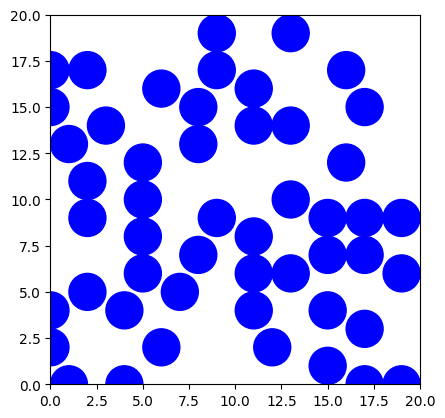

Episode 2
Test Episode 2, Reward: -60, Done: True, Iterations: 110, Remaining Disks: 0, Nb disks: 50


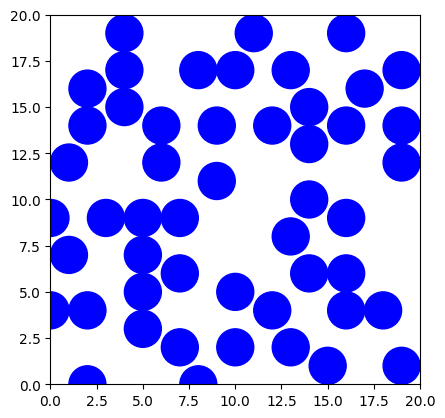

In [23]:
num_episodes = 2
for episode in range(num_episodes):
    obs = env.reset()
    done = False
    iteration = 0
    total_reward = 0

    print(f"Episode {episode + 1}")

    while not done and iteration < 500:
        action = env.action_space.sample()  # Random action
        obs, reward, done, _ = env.step(action)
        total_reward += reward
        
        iteration += 1

    print(f"Test Episode {episode + 1}, Reward: {total_reward}, Done: {done}, Iterations: {iteration}, Remaining Disks: {env.remaining_disks}, Nb disks: {len(env.disk_positions)}")
    # Render the environment
    env.render()

# After testing, close the environment
plt.close('all')